In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import train_test_split , GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import sys
import os
sys.path.append(os.path.abspath('../../../../src'))


### Data loading and pre-processing (this will later be replaced by scripts)

In [15]:
from scripts.data_processing import load_and_preprocess_data

data_path = '../../../../data/raw/winequalityN.csv'
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_path)

#### Random forest model experimenting

In [16]:
clf = RandomForestClassifier(random_state= 42)

params = {
    'max_depth': range(1 , 30, 5),
    'n_estimators': range(1 , 25, 5),
    'min_samples_split': range(2 , 10 , 2)
}

# We use GridSearchCV to find the best hyperparameters for our model
grid_search = GridSearchCV(clf , param_grid= params , cv= 5 , n_jobs= -1, verbose= 1, scoring= 'accuracy')

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 30, 5),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(1, 25, 5)},
             scoring='accuracy', verbose=1)

In [17]:
best = [grid_search.best_params_, grid_search.best_score_]
best

[{'max_depth': 26, 'min_samples_split': 2, 'n_estimators': 21},
 np.float64(0.9400203951312325)]

In [18]:
grid_search.best_params_
y_pred = grid_search.predict(X_test)
print(y_pred)

accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

['Medium' 'High' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'High' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Low' 'Medium' 'Medium' 'Medium' 'Medium' 'High' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium'
 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medium' 'Medi

In [19]:
print(classification_report(y_test, grid_search.predict(X_test)))

              precision    recall  f1-score   support

        High       0.82      0.40      0.54        35
         Low       0.73      0.27      0.39        30
      Medium       0.95      0.99      0.97       915

    accuracy                           0.95       980
   macro avg       0.84      0.55      0.63       980
weighted avg       0.94      0.95      0.94       980



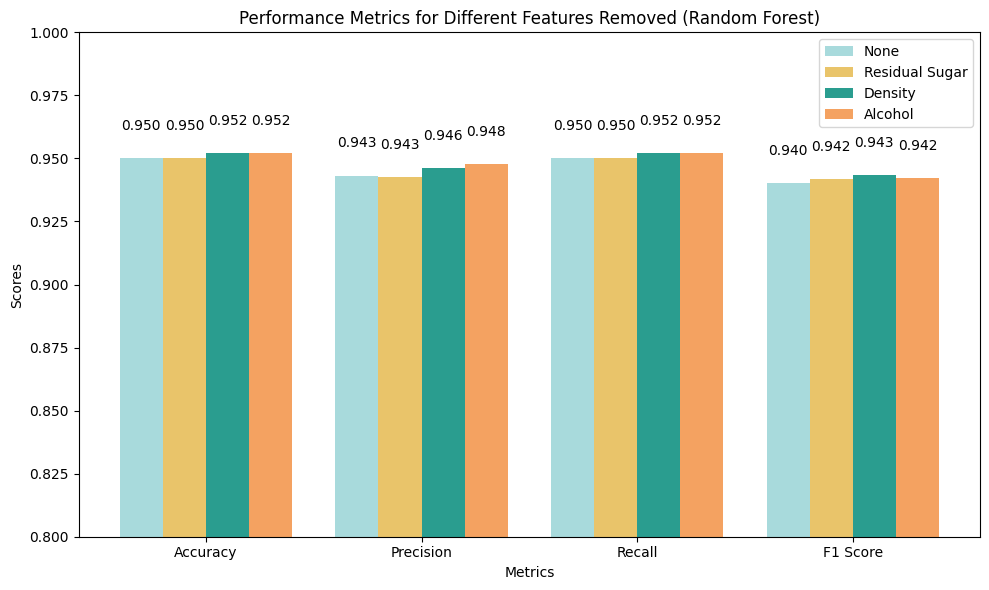

In [21]:
# Define features to test dropping
feature_combinations = {
    'None': [],
    'Residual Sugar': ['residual sugar'],
    'Density': ['density'],
    'Alcohol': ['alcohol']
}

# Dictionary to store results
metrics_scores = {name: [] for name in feature_combinations.keys()}

# For each feature combination
for name, features_to_drop in feature_combinations.items():
    # Load and preprocess data with specified features dropped
    X_train, X_test, y_train, y_test = load_and_preprocess_data(
        data_path, 
        features_to_drop=features_to_drop
    )
    
    # Train model with best parameters from your grid search
    clf = RandomForestClassifier(
        max_depth=26,
        min_samples_split=2,
        n_estimators=21,
        random_state=42
    )
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    metrics_scores[name].extend([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred, average='weighted')
    ])

# Define colors
colors = ['#a8dadc',   # Light blue
          '#e9c46a',   # Muted yellow
          '#2a9d8f',   # Teal
          '#f4a261']   # Soft orange

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Define metrics labels and positions
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metric_labels))
width = 0.2

# Plot bars for each feature combination
for i, (feature, scores) in enumerate(metrics_scores.items()):
    offset = width * (i - len(metrics_scores)/2 + 0.5)
    bars = ax.bar(x + offset, scores, width, 
                 label=feature, color=colors[i])
    
    # Add value labels on top of bars
    for j, v in enumerate(scores):
        ax.text(x[j] + offset, v + 0.01, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Different Features Removed (Random Forest)')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0.8, 1)  # Adjust as needed
ax.legend()

plt.tight_layout()
plt.savefig('../../../data/eval_results/RF_features_removed.png', dpi=300, bbox_inches='tight')
plt.show()